In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_blobs, load_iris
from sklearn.model_selection import train_test_split

In [8]:
class SVMClassifier(torch.nn.Module):
    def __init__(self, kernel="linear", lambda_param=0.01, n_iters=1000):
        super(SVMClassifier, self).__init__()
        self.bias = None
        self.lambda_param = 0.01
        self.n_iters = 1000
        self.kernel = getattr(self, f"_{kernel}")

    def _preprocess_labels(self, y):
        y = torch.tensor(y)
        y_ = torch.where(y <= 0, -1, 1)
        return y_.float()

    def _linear(self, X1, X2):
        return X1 @ X2.T

    def _polynomial(self, X1, X2, degree=3):
        return (X1 @ X2.T + 1) ** degree

    def _rbf(self, X1, X2, gamma=0.1):
        x1_sq = (X1**2).sum(dim=1, keepdim=True)
        x2_sq = (X2**2).sum(dim=1, keepdim=True)
        dist = x1_sq + x2_sq.T - 2 * X1 @ X2.T
        return torch.exp(-gamma * dist)

    def _decision_function(self, X):
        K = self.kernel(X, self.sv_X)
        return (self.sv_alpha * self.sv_y) @ K.T + self.bias

    def fit(self, X, y):
        y = self._preprocess_labels(y)
        X = torch.tensor(X, dtype=torch.float32)

        n_samples, n_features = X.shape
        alpha = torch.zeros(n_samples, dtype=torch.float32, requires_grad=True)
        K = self.kernel(X, X)

        optimizer = torch.optim.SGD([alpha], lr=0.01)
        for _ in range(self.n_iters):
            optimizer.zero_grad()
            loss = -torch.sum(alpha) + 0.5 * torch.sum(
                (alpha * y)[:, None] * (alpha * y)[None, :] * K
            )
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                alpha.clamp_(0, 1 / (2 * self.lambda_param * n_samples))

        self.alpha = alpha.detach()
        sv_mask = self.alpha > 1e-6
        self.sv_X = X[sv_mask]
        self.sv_y = y[sv_mask]
        self.sv_alpha = self.alpha[sv_mask]
        self.bias = torch.mean(self.sv_y - self._decision_function(self.sv_X))

    def predict(self, X):
        return torch.sign(
            self._decision_function(torch.tensor(X, dtype=torch.float32))
        ).numpy()

    def accuracy(self, y_true, y_pred):
        y_true = self._preprocess_labels(y_true)
        correct = (y_true == y_pred).sum().item()
        return correct / len(y_true)

In [9]:
svm = SVMClassifier()
X, y = make_blobs(n_samples=200, centers=2, random_state=6)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
svm.fit(X_train, y_train)

TypeError: unsupported operand type(s) for +: 'Tensor' and 'NoneType'

In [ ]:
y_pred = svm.predict(X_test)
accuracy = svm.accuracy(y_test, y_pred)
print(f"SVM Test Accuracy: {accuracy * 100:.2f}%")

RuntimeError: The size of tensor a (40) must match the size of tensor b (82) at non-singleton dimension 0

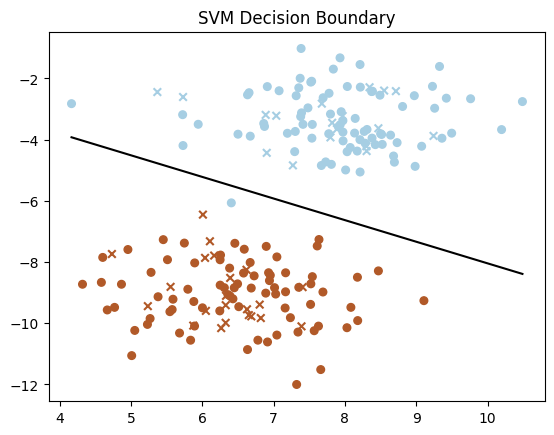

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=30, cmap=plt.cm.Paired, marker="x")
x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
y = -(svm.weights[0].item() * x + svm.bias.item()) / svm.weights[1].item()
plt.plot(x, y, "k-")
plt.title("SVM Decision Boundary")
plt.show()